In [10]:
#necessary imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import glob
import cv2
import os
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from tqdm import tqdm
from google.colab import files

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Load Data including masks and images
phys_images = glob.glob("/content/drive/My Drive/archive-3/images/*.png")
phys_images.sort()
labels = glob.glob("/content/drive/My Drive/archive-3/masks/*.png")
labels.sort()
# load images and normalize
phys = []
for img in phys_images:
    n = cv2.imread(img)
    n = cv2.cvtColor(n, cv2.COLOR_BGR2RGB)
    n = cv2.resize(n, (256, 256), interpolation = cv2.INTER_AREA)
    n = n/255.0
    phys.append(n)
masks = []
for img in labels:
    n = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    n= cv2.resize(n, (256,256), interpolation = cv2.INTER_AREA)
    masks.append(n)

In [12]:
# Create x and y data
x_data= np.array(phys)
y_data = np.array(masks)
#print(y_train.shape)
y_data = np.eye(3)[y_data]


(292, 256, 256, 3) (292, 256, 256, 3)
(74, 256, 256, 3) (74, 256, 256, 3)


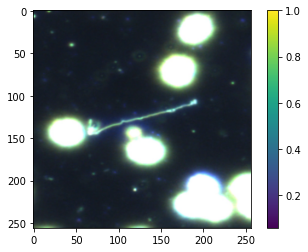

In [13]:

x_train = x_data[range(0,292)]
y_train = y_data[range(0,292)]
x_val = x_data[range(292,len(x_data))]
y_val = y_data[range(292,len(y_data))]

# crop to size for training

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

#plot x_data to see if data loaded correctly
plt.imshow(x_train[4,:,:])
plt.colorbar()

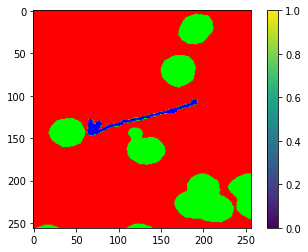

In [14]:
#plot label data
plt.imshow(y_train[4,:,:])
plt.colorbar()

In [6]:
# UNET Model
class UNet(tf.keras.models.Model):
  def __init__(self):
    super().__init__()

    self.conv1 = tf.keras.layers.Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch1 = tf.keras.layers.BatchNormalization()
    self.conv2 = tf.keras.layers.Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch2 = tf.keras.layers.BatchNormalization()
    self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
    self.conv3 = tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch3 = tf.keras.layers.BatchNormalization()
    self.conv4 = tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch4 = tf.keras.layers.BatchNormalization()
    self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))
    self.conv5 = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch5 = tf.keras.layers.BatchNormalization()
    self.conv6 = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch6 = tf.keras.layers.BatchNormalization()
    self.pool3 = tf.keras.layers.MaxPooling2D(pool_size = (2,2))
    self.conv7 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch7 = tf.keras.layers.BatchNormalization()
    self.conv8 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch8 = tf.keras.layers.BatchNormalization()
    self.pool4 = tf.keras.layers.MaxPooling2D(pool_size = (2,2))

    self.conv9 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch9 = tf.keras.layers.BatchNormalization()
    self.conv10 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch10 = tf.keras.layers.BatchNormalization()
    
    self.up1 = tf.keras.layers.UpSampling2D(size = (2,2))
    self.conv11 = tf.keras.layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    #merge after this step
    self.conv12 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch11 = tf.keras.layers.BatchNormalization()
    self.conv13 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch12 = tf.keras.layers.BatchNormalization()
    self.up2 = tf.keras.layers.UpSampling2D(size = (2,2))
    self.conv14 = tf.keras.layers.Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    #merge after this step
    self.conv15 = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch13 = tf.keras.layers.BatchNormalization()
    self.conv16 = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch14 = tf.keras.layers.BatchNormalization()
    self.up3 = tf.keras.layers.UpSampling2D(size = (2,2))
    self.conv17 = tf.keras.layers.Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    #Merge after this step
    self.conv18 = tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch15 = tf.keras.layers.BatchNormalization()
    self.conv19 = tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch16 = tf.keras.layers.BatchNormalization()
    self.up4 = tf.keras.layers.UpSampling2D(size = (2,2))
    self.conv20 = tf.keras.layers.Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    #Merge after this step
    self.conv21 = tf.keras.layers.Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch17 = tf.keras.layers.BatchNormalization()
    self.conv22 = tf.keras.layers.Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch18 = tf.keras.layers.BatchNormalization()
    self.conv23 = tf.keras.layers.Conv2D(3, 1, activation = 'softmax', padding = 'same', kernel_initializer = 'he_normal')
  
  def call(self, input):  
    conv1 = self.conv1(input)
    conv1 = self.batch1(conv1)
    conv1 = self.conv2(conv1)
    conv1 = self.batch2(conv1)
    pool1 = self.pool1(conv1)

    conv2 = self.conv3(pool1)
    conv2 = self.batch3(conv2)
    conv2 = self.conv4(conv2)
    conv2 = self.batch4(conv2)
    pool2 = self.pool2(conv2)

    conv3 = self.conv5(pool2)
    conv3 = self.batch5(conv3)
    conv3 = self.conv6(conv3)
    conv3 = self.batch6(conv3)
    pool3 = self.pool3(conv3)

    conv4 = self.conv7(pool3)
    conv4 = self.batch7(conv4)
    conv4 = self.conv8(conv4)
    drop4 = self.batch8(conv4)
    pool4 = self.pool4(drop4)

    conv5 = self.conv9(pool4)
    conv5 = self.batch9(conv5)
    conv5 = self.conv10(conv5)
    drop5 = self.batch10(conv5)

    up6 = self.up1(drop5)
    up6 = self.conv11(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = self.conv12(merge6)
    conv6 = self.batch11(conv6)
    conv6 = self.conv13(conv6)
    conv6 = self.batch12(conv6)

    up7 = self.up2(conv6)
    up7 = self.conv14(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = self.conv15(merge7)
    conv7 = self.batch13(conv7)
    conv7 = self.conv16(conv7)
    conv7 = self.batch14(conv7)

    up8 = self.up3(conv7)
    up8 = self.conv17(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = self.conv18(merge8)
    conv8 = self.batch15(conv8)
    conv8 = self.conv19(conv8)
    conv8 = self.batch16(conv8)

    up9 = self.up4(conv8)
    up9 = self.conv20(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = self.conv21(merge9)
    conv9 = self.batch17(conv9)
    conv9 = self.conv22(conv9)
    conv9 = self.batch18(conv9)

    return self.conv23(conv9)

model = UNet()


In [7]:
model.compile(optimizer=Adam(lr=1e-3),  # Optimizer
              loss='categorical_crossentropy',  # Loss
                      metrics=['accuracy'])  # Metric to monitor
history = model.fit(x_train, y_train, batch_size=32, epochs=25, validation_data=(x_val, y_val))

Epoch 1/25
10/10 [==============================] - 127s 12s/step - loss: 1.4766 - accuracy: 0.2644 - val_loss: 0.9771 - val_accuracy: 0.5847
Epoch 2/25
10/10 [==============================] - 124s 12s/step - loss: 0.9603 - accuracy: 0.6075 - val_loss: 0.7442 - val_accuracy: 0.7827
Epoch 3/25
10/10 [==============================] - 120s 12s/step - loss: 0.8419 - accuracy: 0.7441 - val_loss: 1.1008 - val_accuracy: 0.7252
Epoch 4/25
10/10 [==============================] - 120s 12s/step - loss: 0.7816 - accuracy: 0.8081 - val_loss: 1.2596 - val_accuracy: 0.6858
Epoch 5/25
10/10 [==============================] - 121s 12s/step - loss: 0.7319 - accuracy: 0.8335 - val_loss: 0.9348 - val_accuracy: 0.7927
Epoch 6/25
10/10 [==============================] - 121s 12s/step - loss: 0.6624 - accuracy: 0.8689 - val_loss: 1.0449 - val_accuracy: 0.8130
Epoch 7/25
10/10 [==============================] - 120s 12s/step - loss: 0.6036 - accuracy: 0.8905 - val_loss: 0.8573 - val_accuracy: 0.8468
Epoch 

In [9]:
# Save the weights
model.save_weights('/content/drive/MyDrive/Colab Notebooks/my_saved_model2')

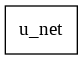

In [34]:
tf.keras.utils.plot_model(model)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/my_saved_model')

In [10]:
preds_val = model.predict(x_val, verbose=1)

3/3 [==============================] - 7s 2s/step


In [11]:
def plot_sample(x, y, preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(x[ix, ..., 0], cmap='gray')
    #ax[0].contour(tf.squeeze(y[ix]))#, colors='k', levels=[0.5])
    ax[0].set_title('Original Image')

    ax[1].imshow(y[ix])
    ax[1].set_title('Ground Truth Mask')

    ax[2].imshow(preds[ix])
    #ax[2].contour(tf.squeeze(y[ix]))#, colors='k', levels=[0.5]))
    ax[2].set_title('UNet Predicted Mask')

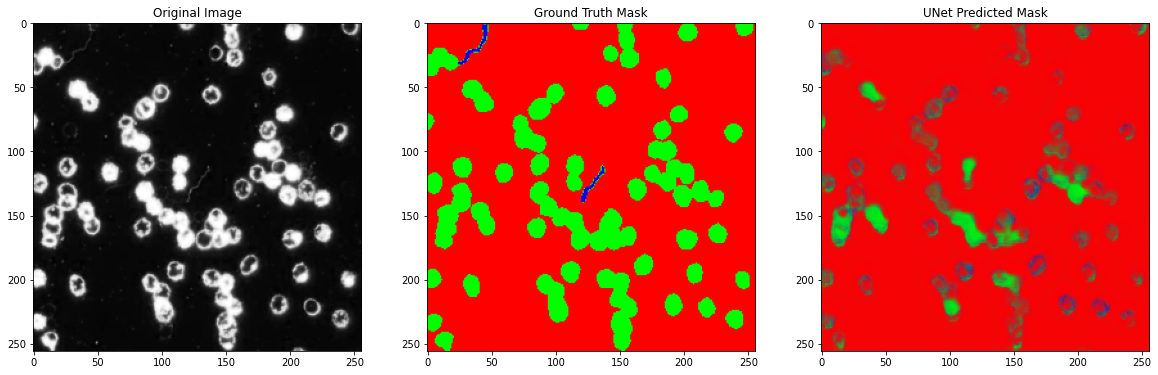

In [27]:
plot_sample(x_val, y_val, preds_val, 3)
plt.savefig('nophysicallayerpredbad.jpeg')

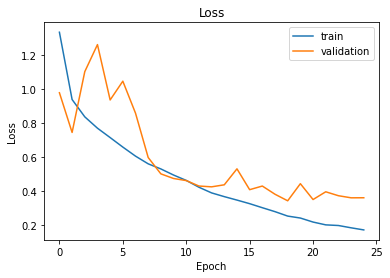

<Figure size 432x288 with 0 Axes>

In [29]:
plt.figure()
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "validation"], loc="upper right")
plt.show()
plt.savefig("lossnolayer1.png")



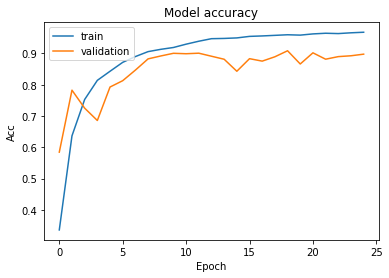

<Figure size 432x288 with 0 Axes>

In [30]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.ylabel("Acc")
plt.xlabel("Epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()
plt.savefig("accuracynolayer.png")